In [ ]:
# conda create --name sig_verif_1 python=3.8.19
# conda activate sig_verif_1
# conda install -c conda-forge numpy=1.24.4 pandas=1.1.4 matplotlib=3.3.3 pillow=8.1.1
# https://pytorch.org/get-started/locally/
# conda install -c conda-forge notebook
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [1]:
import notebook as x; print('Lib:', x.__version__)

# /d/Users/ali/DATA_Cheque/4_Signature_Verification/1_ICDAR_2011/Siamese-1/siamese-net
# echo $CONDA_DEFAULT_ENV

Lib: 7.2.2


In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
import json
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv

In [4]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv, header=None)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
            # image1_path,  # Returns image1 path
            # image2_path,  # Returns image2 path
        )

    def __len__(self):
        return len(self.train_df)

In [5]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

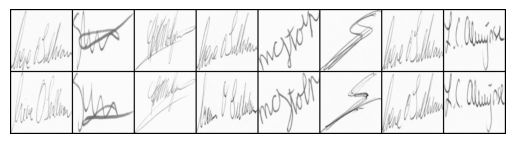

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [6]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# first_column_filenames = example_batch[3]  # These are the filenames for the first image in each pair
# print("First column image filenames:")
# for filename in first_column_filenames:
#     print(filename)

In [7]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),    ####### Use nn.Dropout in newer versions not Dropout2d

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,  #.py file more workers (total=20)
                        batch_size=config.batch_size)

for i, data in enumerate(train_dataloader,0):
    print(i)
    if i> 5 : break

0
1
2
3
4
5
6


# Training

cuda if GPU else CPU: cuda
Epoch 1
 Avg loss 0.24524639010070318
 Lerning Rate 0.001

Epoch 2
 Avg loss 0.07995633019740322
 Lerning Rate 0.001

Epoch 3
 Avg loss 0.07870541155697351
 Lerning Rate 0.001

Epoch 4
 Avg loss 0.07867580481681478
 Lerning Rate 0.001

Epoch 5
 Avg loss 0.0787401961544192
 Lerning Rate 0.001

Epoch 6
 Avg loss 0.0792281971099865
 Lerning Rate 0.001

Epoch 7
 Avg loss 0.07996352848159262
 Lerning Rate 0.001

Epoch 8
 Avg loss 0.0836262813533645
 Lerning Rate 0.001

Epoch 9
 Avg loss 0.0805014620882919
 Lerning Rate 0.001

Epoch 10
 Avg loss 0.07923307589378702
 Lerning Rate 0.0005

Epoch 11
 Avg loss 0.07955457221671759
 Lerning Rate 0.0005

Epoch 12
 Avg loss 0.07919088883931379
 Lerning Rate 0.0005

Epoch 13
 Avg loss 0.07834781115672675
 Lerning Rate 0.0005

Epoch 14
 Avg loss 0.07706460512007575
 Lerning Rate 0.0005

Epoch 15
 Avg loss 0.07748840041907437
 Lerning Rate 0.0005

Epoch 16
 Avg loss 0.07708725352064673
 Lerning Rate 0.0005

Epoch 17
 Avg loss 

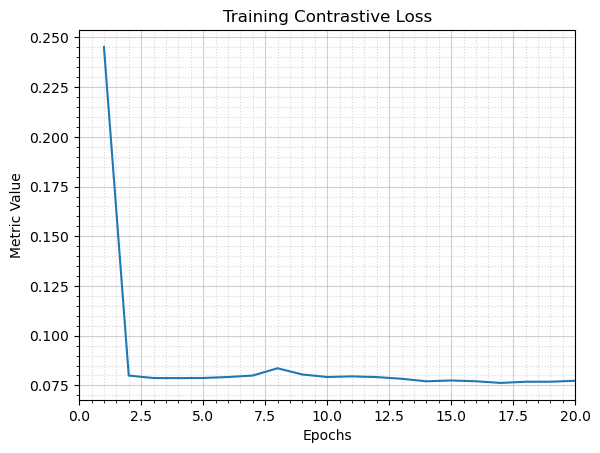

Model Saved Successfully


In [13]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)   # torch.optim.SGD
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#train the model
def train():
    checkpoint_data = {
        'loss': [],
        'counter': [],}
    iteration_number = 0
    L_data = len(train_dataloader)

    for epoch in range(1, 21):  #config.epochs+1 20 epochs
        loss_sum = 0
        for i, data in enumerate(train_dataloader,0):  #726 instances
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()  # gpu
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)  #Gradient Clipping
            loss_sum += loss_contrastive.item()

        iteration_number += 1  # += 10
        avg_loss = loss_sum / L_data
        checkpoint_data['loss'].append(avg_loss)
        checkpoint_data['counter'].append(iteration_number)

        # Adjust learning rate
        scheduler.step(avg_loss)

        print("Epoch {}\n Avg loss {}\n Lerning Rate {}\n".format(epoch, avg_loss, optimizer.param_groups[0]['lr']))

    # show_plot(counter, loss)
    plt.plot(checkpoint_data['counter'], checkpoint_data['loss'], label='Contrastive Loss')
    plt.title('Training Contrastive Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.xlim(0, 20)
    # plt.legend()
    plt.grid(True, linestyle='-', alpha=0.6)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', alpha=0.5)
    plt.show()
    return net, optimizer, checkpoint_data

#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model, optimizer, summary = train()

# torch.save(model.state_dict(), f"content/saved_model.pt")
torch.save(model, f"content/saved_model_full_removed_leakage2.pt")
torch.save(optimizer, f"content/saved_optimizer.pt")
print("Model Saved Successfully")

___

# Training outputs statistics

In [ ]:
# see training model output
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#train the model
threshold=0.1
checkpoint_data = {
    'loss': [],
    'counter': [],
    'loss_forged' : [],
    'loss_original': [],}

iteration_number = 0
L_data = len(train_dataloader)

for epoch in range(1, 5):  # config.epochs + 1 for 20 epochs

    loss_sum = 0
    loss_forged_sum = 0  # Initialize forged loss sum
    loss_original_sum = 0  # Initialize original loss sum
    forged_count = 0  # Counter for forged pairs
    original_count = 0  # Counter for original pairs

    all_predictions = []
    all_labels = []
    
    for i, data in enumerate(train_dataloader, 0):  # 726 instances
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        loss_sum += loss_contrastive.item()

        # Separate losses for forged and original pairs
        for j in range(label.size(0)):  # Loop through each sample in the batch
            if label[j].item() == 1:  # Forged pair
                loss_forged_sum += criterion(output1[j:j+1], output2[j:j+1], label[j:j+1]).item()
                forged_count += 1
            else:  # Original pair
                loss_original_sum += criterion(output1[j:j+1], output2[j:j+1], label[j:j+1]).item()
                original_count += 1
    
    iteration_number += 10
    avg_loss = loss_sum / L_data
    avg_loss_forged = loss_forged_sum / forged_count if forged_count > 0 else 0  # Average loss for forged pairs
    avg_loss_original = loss_original_sum / original_count if original_count > 0 else 0  # Average loss for original pairs

    checkpoint_data['loss'].append(avg_loss)
    checkpoint_data['counter'].append(iteration_number)
    checkpoint_data['loss_forged'].append(avg_loss_forged)
    checkpoint_data['loss_original'].append(avg_loss_original)

    # Adjust learning rate
    scheduler.step(avg_loss)

    # Epoch Summary
    print(f"Epoch {epoch} Summary:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Loss for Forged Pairs: {avg_loss_forged:.4f}")
    print(f"Average Loss for Original Pairs: {avg_loss_original:.4f}")

___

# Inference

In [14]:
import json

# Assuming summary is a dictionary or serializable object
with open('./content/model_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [15]:
# model = torch.load("content/saved_model_full_removed_leakage.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model.to(device)
model.eval()  # important for layers like dropout or batch normalization

# Load the test dataset
test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)  #num_workers=8

cuda if GPU else CPU: cuda


Pairs Of Signatures


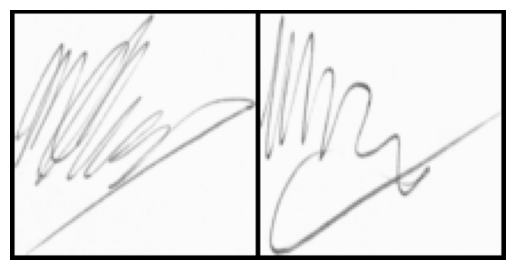

Predicted Eucledian Distance: 0.1126
Contrastive Loss: 0.1501
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


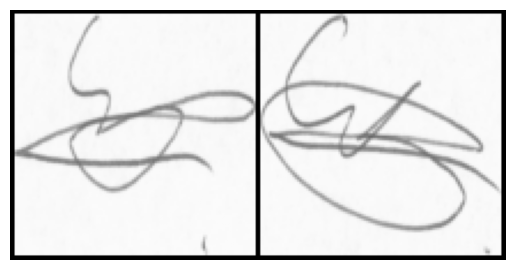

Predicted Eucledian Distance: 0.0176
Contrastive Loss: 0.0003
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


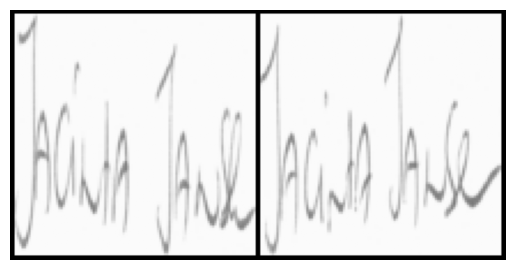

Predicted Eucledian Distance: 0.0628
Contrastive Loss: 0.0039
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


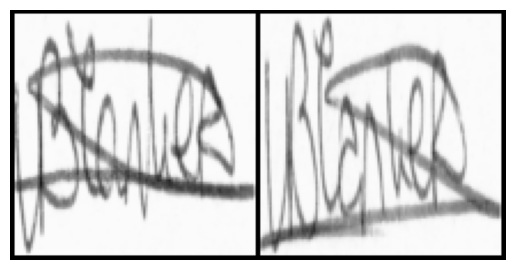

Predicted Eucledian Distance: 0.053
Contrastive Loss: 0.0028
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


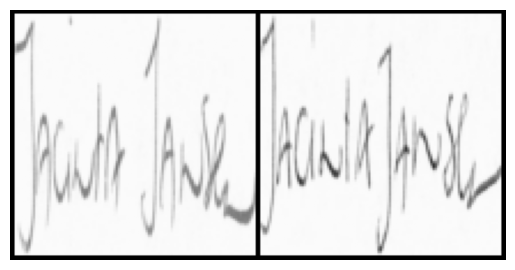

Predicted Eucledian Distance: 0.029
Contrastive Loss: 0.2218
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


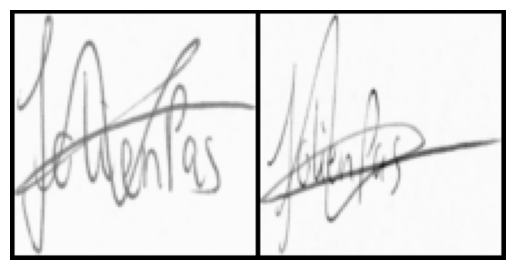

Predicted Eucledian Distance: 0.0906
Contrastive Loss: 0.1676
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


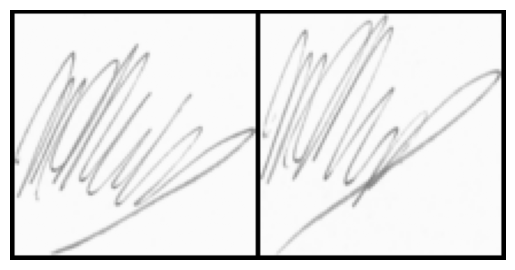

Predicted Eucledian Distance: 0.0115
Contrastive Loss: 0.0001
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


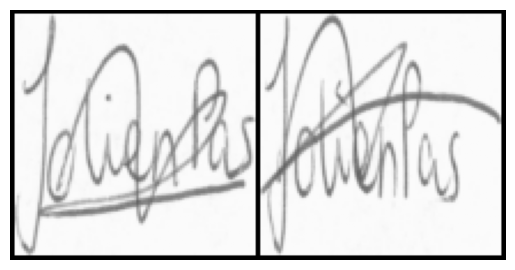

Predicted Eucledian Distance: 0.1061
Contrastive Loss: 0.0113
Actual Label: Original
Predicted: Original
-------------------------------------------------------------------


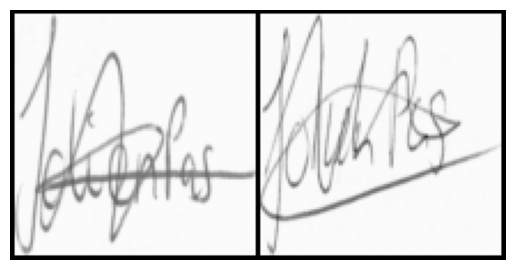

Predicted Eucledian Distance: 0.0605
Contrastive Loss: 0.1931
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


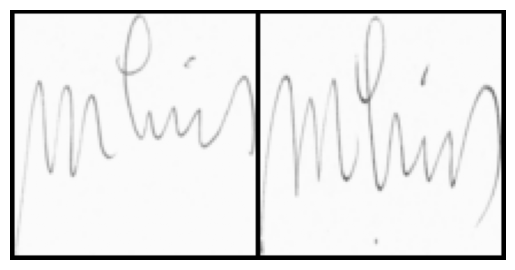

Predicted Eucledian Distance: 0.0335
Contrastive Loss: 0.2176
Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


In [16]:
threshold = 0.1  # Adjust; very small is not good for generalization
contrastive_loss_fn = ContrastiveLoss()

print("Pairs Of Signatures")

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1,output2 = model(x0.to(device),x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label.item() == 0:  #label == torch.FloatTensor([[0]]):
        label_text = "Original"
    else:
        label_text = "Forged"

    # Calculate contrastive loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = contrastive_loss_fn(output1, output2, label_tensor)

    # Predict based on threshold
    prediction = "Forged" if loss > threshold else "Original"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:", round(eucledian_distance.item(), 4))
    print(f"Contrastive Loss: {loss.item():.4f}")
    print("Actual Label:", label_text)
    print(f"Predicted: {prediction}")
    print("-" * 67)
    count = count + 1
    if count == 10:
        break

# Performance Metrics for testing dataset

In [20]:
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

threshold = 0.05  # Adjust threshold
contrastive_loss_fn = ContrastiveLoss()

print("Pairs Of Signatures")

L_data_test = len(test_dataloader)
count = 0

for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # Calculate contrastive loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = contrastive_loss_fn(output1, output2, label_tensor)

    # Predict based on threshold
    prediction = (loss > threshold).float()  # 1 for "Forged", 0 for "Original"
    
    # Store predictions and labels for metrics calculation
    all_predictions.append(prediction.item())
    all_labels.append(label.item())

    # Visualize and print individual results
    if label.item() == 0:
        label_text = "Original"
    else:
        label_text = "Forged"


# Calculate performance metrics
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# Precision
precision = precision_score(all_labels, all_predictions, pos_label=1)

# Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, pos_label=1)

# Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
specificity = tn / (tn + fp)

# F1 Score
f1 = f1_score(all_labels, all_predictions, pos_label=1)

# Print metrics
print(f"\nPerformance Metrics on Test Data ({L_data_test} images, Contrastive Loss threshold for classification = {threshold}):\n")
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"TN: {tn:.3f} | FP: {fp:.3f} | FN: {fn:.3f} | TP: {tp:.3f}")

Pairs Of Signatures

Performance Metrics on Test Data (3639 images, Contrastive Loss threshold for classification = 0.05):

Accuracy: 1.000
Balanced Accuracy: 1.000
Precision: 1.000
Recall (Sensitivity): 1.000
Specificity: 1.000
F1 Score: 1.000
TN: 1399.000 | FP: 0.000 | FN: 0.000 | TP: 2240.000


# Statistics for Loss during testing

In [19]:
criterion = ContrastiveLoss()

# Initialize lists to store distances and labels
distances = []
labels = []
losses = []

# Loop through the test data
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    # Calculate Euclidean distance
    eucledian_distance = F.pairwise_distance(output1, output2).item()
    loss = criterion(output1, output2, label.to(device)).item()

    # Append distance and label to lists
    distances.append(eucledian_distance)
    labels.append("Genuine" if label.item() == 0 else "Forged")   #labels.append("Genuine" if label == torch.FloatTensor([[0]]) else "Forged")
    losses.append(loss)

    count += 1
#-------------------------------------------------------------------------------------
# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "Distance": distances,
    "Loss": losses,
    "Label": labels
})

# Calculate statistics for genuine and forged pairs
genuine_stats = results_df[results_df["Label"] == "Genuine"][["Distance", "Loss"]].describe()
forged_stats = results_df[results_df["Label"] == "Forged"][["Distance", "Loss"]].describe()

# Print statistics
print("Genuine Pair Statistics:\n", genuine_stats)
print("\nForged Pair Statistics:\n", forged_stats)


Genuine Pair Statistics:
           Distance         Loss
count  1399.000000  1399.000000
mean      0.043082     0.002789
std       0.030555     0.003838
min       0.001092     0.000001
25%       0.019971     0.000399
50%       0.034950     0.001221
75%       0.060217     0.003626
max       0.167351     0.028006

Forged Pair Statistics:
           Distance         Loss
count  2240.000000  2240.000000
mean      0.067363     0.189094
std       0.043812     0.036248
min       0.000609     0.074064
25%       0.032919     0.164866
50%       0.057317     0.195968
75%       0.093964     0.218165
max       0.227854     0.249391
